In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import scipy.linalg as la
import scipy.stats as stats

In [4]:
import pyarrow

# 1. parameters

In [5]:
T = 120
N = 100000

In [6]:
d = 3
## order: 1, U, X, A, I
alpha = np.array([0, 0.5, 0, 1, 0])
# beta = np.array([1, -0.2, 0, 0, 0])
gamma = np.array([-2.5, 0, 0, 4, 100/N])
phi = 0.95

In [7]:
betas = np.array([
    np.linspace(1, 1.5, 21),     
    np.linspace(0.3, 0.3, 21),
    np.linspace(0, 0, 21),
    np.linspace(0, -1, 21),
    np.linspace(0, 0, 21)
]).T

$$P_t = 1 - \exp\{- \frac{\rho_t}{N} h I_t\}$$

$$\rho_t = \exp\{ - \beta_1 - \beta_A A_t - \beta_U U_t - \beta_X X_t \}$$

In [22]:
pC = 0.2
pD = 0.2

## seed values

In [19]:
I0 = 100
E0 = 0
S0 = N - E0 - I0

# 2. simulation

In [20]:
num_sim = 1000

## random seed

In [21]:
np.random.seed(1234)

## data generation

In [12]:
for iter_beta, beta in enumerate(betas):
    U = np.random.multivariate_normal(np.zeros(T), phi ** np.abs(np.arange(T)[:,None] - np.arange(T)), num_sim)
    X = np.zeros((num_sim, T))
    pA = np.zeros((num_sim, T))
    A = np.zeros((num_sim, T))

    rho = np.zeros((num_sim, T))
    pB = np.zeros((num_sim, T))
    B = np.zeros((num_sim, T), dtype=int)
    C = np.zeros((num_sim, T), dtype=int)
    D = np.zeros((num_sim, T), dtype=int)

    S = np.zeros((num_sim, T), dtype=int)
    E = np.zeros((num_sim, T), dtype=int)
    I = np.zeros((num_sim, T), dtype=int)

    X[:,0] = alpha[0] + alpha[1]*U[:,0] + np.random.normal(0,0.3,num_sim)

    pA[:,0] = 0
    A[:,0] = np.random.binomial(1, pA[:,0])

    rho[:,0] = np.exp(- beta[0] - beta[1]*U[:,0] - beta[2]*X[:,0] - beta[3]*A[:,0])
    pB[:,0] = 1 - np.exp(- rho[:,0] * I0 / N)
    B[:,0] = np.random.binomial(S0, pB[:,0])
    C[:,0] = np.random.binomial(E0, pC)
    D[:,0] = np.random.binomial(I0, pD)

    S[:,0] = S0 - B[:,0]
    E[:,0] = E0 + B[:,0] - C[:,0]
    I[:,0] = I0 + C[:,0] - D[:,0]

    for t in np.arange(1,T):
        X[:,t] = (alpha[0] + alpha[1]*U[:,t] + alpha[2]*X[:,t-1] 
                  + alpha[3]*A[:,t-1] + alpha[4]*D[:,t-1] 
                  + np.random.normal(0,0.3,num_sim))

        pA[:,t] = 1 - 1/(1 + np.exp(np.clip(
            gamma[0] + gamma[1]*U[:,t] + gamma[2]*X[:,t] 
            + gamma[3]*A[:,t-1] + gamma[4]*D[:,t-1],
            -4, 4
        )))
        A[:,t] = np.random.binomial(1, pA[:,t])

        rho[:,t] = np.exp(- beta[0] - beta[1]*U[:,t] - beta[2]*X[:,t] 
                          - beta[3]*A[:,t] - beta[4]*D[:,t-1])
        pB[:,t] = 1 - np.exp(- rho[:,t] * I[:,t-1] / N)
        B[:,t] = np.random.binomial(S[:,t-1], pB[:,t])
        C[:,t] = np.random.binomial(E[:,t-1], pC)
        D[:,t] = np.random.binomial(I[:,t-1], pD)

        S[:,t] = S[:,t-1] - B[:,t]
        E[:,t] = E[:,t-1] + B[:,t] - C[:,t]
        I[:,t] = I[:,t-1] + C[:,t] - D[:,t]
        
    data = {
        'sim': np.tile(np.arange(num_sim)[:,None], (1,T)).flatten(),
        'date': np.tile(np.arange(T), (num_sim,1)).flatten(),
        'phantom': U.flatten(),
        'covariate': X.flatten(),
        'pA': pA.flatten(),
        'intervention': A.flatten(),
        'rho': rho.flatten(),
        'pB': pB.flatten(),
        'susceptible': S.flatten(),
        'exposure': B.flatten(),
        'exposed': E.flatten(),
        'infection': C.flatten(),
        'infected': I.flatten(),
        'death': D.flatten()
    }
    
    df = pd.DataFrame(data)
    df.to_feather('data/simulation_phantom_null_%.2d.feather'%iter_beta)

# 3. check data

In [12]:
iter_beta = 0
iter_sim = 10

In [13]:
data = pd.read_feather('data/simulation_phantom_null_%.2d.feather'%iter_beta)

In [14]:
I = data["infection"].to_numpy().reshape([num_sim, T])

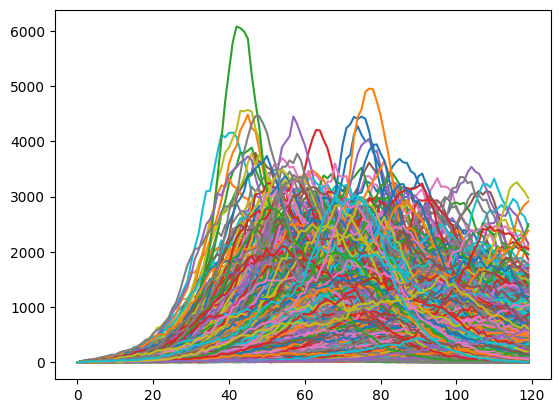

In [15]:
plt.plot(I.T)
plt.show()

In [16]:
S = data["susceptible"].to_numpy().reshape([num_sim, T])

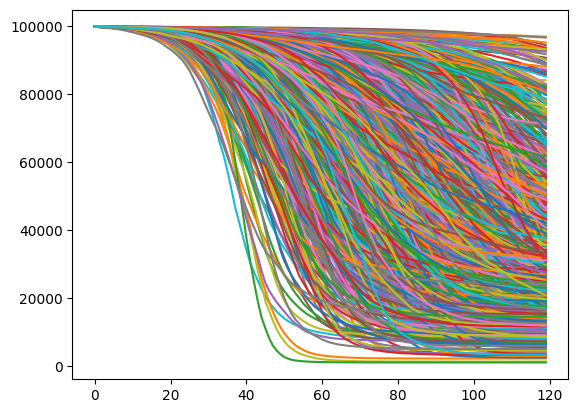

In [17]:
plt.plot(S.T)
plt.show()

In [17]:
data_i = data[data['sim']==iter_sim]
A = np.stack([np.full(T, 1), data_i["covariate"].to_numpy(), 
              data_i["intervention"].to_numpy()], -1)
Y = data_i["death"].to_numpy()

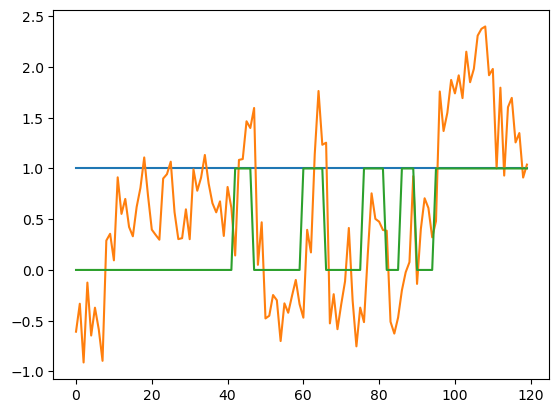

In [18]:
plt.plot(A)

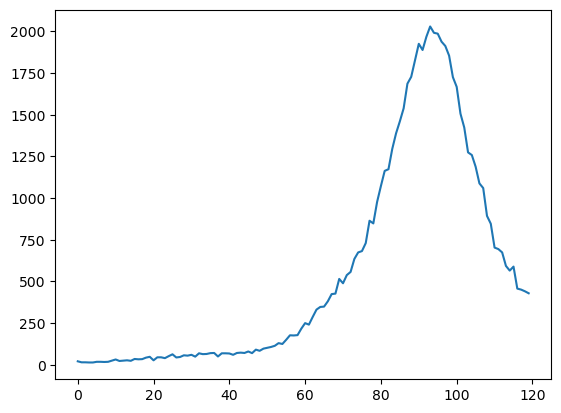

In [19]:
plt.plot(Y)